In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [2]:
df = pd.read_csv("E:/research work/2020-21 paper/test-train/3000Tweet-withLDA.csv")

In [3]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,topic_no,tweet
0,5,3,1,2,0,1,10,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
1,6,3,0,3,0,1,8,"!!!!!!""@__BrighterDays: I can not just sit up ..."
2,10,3,0,3,0,1,1,""" Keeks is a bitch she curves everyone "" lol I..."
3,11,3,0,3,0,1,14,""" Murda Gang bitch its Gang Land """
4,12,3,0,2,1,1,4,""" So hoes that smoke are losers ? "" yea ... go..."
...,...,...,...,...,...,...,...,...
2995,5119,3,0,2,1,1,4,@TheSeanyV subtweeting and using hashtag oomf ...
2996,5120,3,0,0,3,2,23,@TheSeanyV would help for some others can't ha...
2997,5121,3,0,1,2,2,12,@TheShoeBible @Steamed_Greens Them hoes are cl...
2998,5122,3,0,3,0,1,11,@TheSicThem @AVeraIcon @lrishGirI__ @OakRidgeS...


In [4]:
df.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,topic_no
count,3000.00000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,3128.95000,3.182333,0.382667,2.191000,0.608667,1.089333,12.432667
std,1434.53514,0.763729,0.739650,1.355408,1.173876,0.524828,6.929223
min,5.00000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2526.75000,3.000000,0.000000,1.000000,0.000000,1.000000,7.000000
50%,3360.50000,3.000000,0.000000,3.000000,0.000000,1.000000,12.000000
75%,4268.25000,3.000000,1.000000,3.000000,1.000000,1.000000,18.000000
max,5123.00000,9.000000,6.000000,9.000000,9.000000,2.000000,24.000000


In [5]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'topic_no', 'tweet'],
      dtype='object')

<AxesSubplot:>

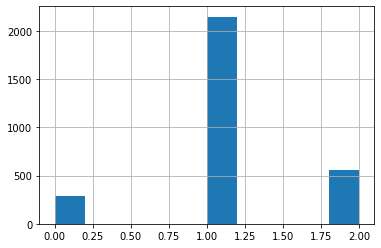

In [6]:
df['class'].hist()

<AxesSubplot:>

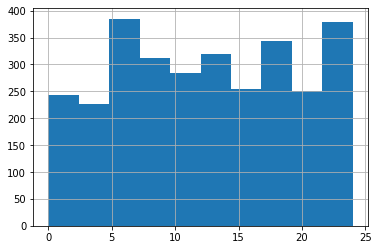

In [7]:
df['topic_no'].hist()

In [8]:
tweets=df.tweet

In [9]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [10]:
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()}

C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [11]:
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [12]:
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [13]:
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [14]:
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [15]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [16]:
feats = get_feature_array(tweets)

In [17]:
M = np.concatenate([tfidf,pos,feats],axis=1)

In [18]:
M.shape

(3000, 2336)

In [19]:
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

In [20]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [23]:
select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l2",C=0.01))
X_ = select.fit_transform(X,y)

C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
model = LinearSVC(class_weight='balanced',C=0.01, penalty='l2', loss='squared_hinge',multi_class='ovr').fit(X_, y)

In [27]:
model = LogisticRegression(class_weight='balanced',penalty='l2',C=0.01).fit(X_,y)

C:\Users\Asus\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
y_preds = model.predict(X_)

In [29]:
report = classification_report( y, y_preds )

In [30]:
print(report)

              precision    recall  f1-score   support

           0       0.67      0.99      0.80       291
           1       1.00      0.87      0.93      2150
           2       0.81      0.99      0.89       559

    accuracy                           0.91      3000
   macro avg       0.82      0.95      0.87      3000
weighted avg       0.93      0.91      0.91      3000



In [31]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [32]:
confusion_matrix( y, y_preds )

array([[ 287,    2,    2],
       [ 140, 1879,  131],
       [   1,    6,  552]], dtype=int64)